In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt

In [3]:
#mnist 데이터 일부를 이미지 출력하기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

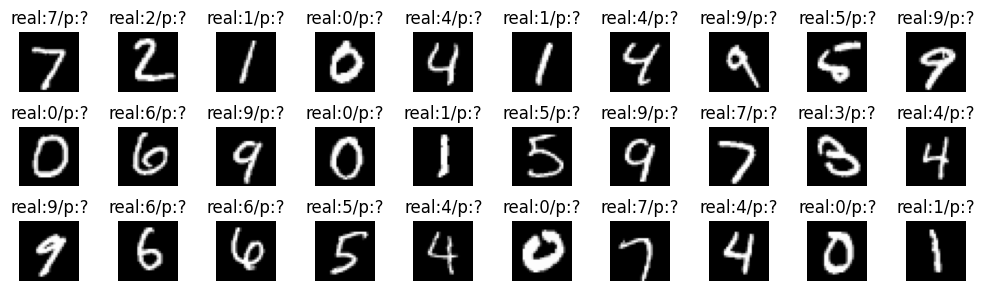

In [18]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col, plt_row))
plt.rcParams['figure.figsize']=(plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# axarr[0,0].imshow(X_test[0], cmap='gray')
# axarr[0,0].axis('off')
# axarr[0,0].set_title(f'real:{y_test[0]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col,i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'real:{y_test[i]}/p:?')
plt.tight_layout()
plt.show()

# 1. DNN

In [23]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train 데이터 6만개 => Train(5만개) + Val(1만개) 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n,28,28) -> (n,28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 28*28).astype('float32')/255.0
test_X = X_test.reshape(-1, 28*28).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
# to_categorical(y_train)
train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)


model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', #sparse_categorical_crossentropy : 원핫인코딩하지 않았을경우
             optimizer='adam',
             metrics=['accuracy'])
hist = model.fit(train_X, train_Y, #학습셋
                epochs=50, batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)

CPU times: total: 20min 15s
Wall time: 4min 1s


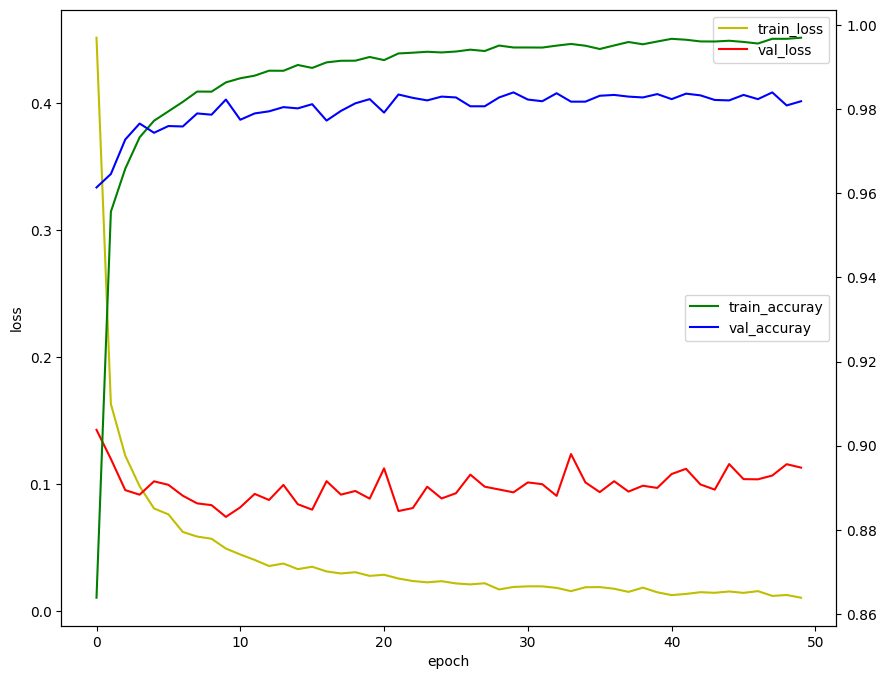

In [24]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuray')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [25]:
# 모델 평가하기
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9850000143051147

In [27]:
# 틀린갯수
len(test_Y) - len(test_Y)*acc

149.99985694885254

In [29]:
# 틀린 이미지만 출력하기 위해, 예측값과 실제값
real = y_test # 실제값
pred = model.predict(test_X).argmax(axis=1) # 예측값

313/313 [==============================] - 1s 3ms/step


In [30]:
real.shape, pred.shape

((10000,), (10000,))

In [31]:
pd.crosstab(real, pred, rownames=['실제값'], colnames=['예측값'])

예측값,0,1,2,3,4,5,6,7,8,9
실제값,,,,,,,,,,
0,973,1,0,1,0,1,1,1,1,1
1,0,1126,2,2,0,0,1,0,4,0
2,3,1,1014,2,2,0,1,6,3,0
3,0,0,6,994,0,4,0,4,2,0
4,0,0,1,1,965,0,4,1,1,9
5,2,0,0,8,1,873,3,1,3,1
6,2,3,1,0,1,3,946,0,2,0
7,1,2,8,0,0,0,0,1012,2,3
8,0,0,4,2,2,1,3,2,958,2


In [34]:
plt_row = 15
plt_col = 10
i = 0 # y_hat과 y_test를 엑세스할 인덱스
cnt = 0 # 이미지 출력 횟수 : 1~120
while cnt<plt_row*plt_col and i<len(y_test):
    if (real[i]==pred[i]):
        i += 1
        continue
    title = f'r:{real[i]}/p:{pred[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:5/p:6	r:4/p:2	r:2/p:7	r:5/p:3	r:6/p:0	r:8/p:2	r:8/p:2	r:1/p:8	r:2/p:1	r:7/p:2	r:4/p:9	r:5/p:8	r:8/p:3	r:2/p:7	r:8/p:9	r:5/p:4	r:1/p:2	r:6/p:5	r:7/p:2	r:6/p:8	r:4/p:6	r:7/p:8	r:7/p:2	r:4/p:9	r:9/p:5	r:5/p:7	r:8/p:3	r:8/p:6	r:7/p:9	r:5/p:6	r:5/p:3	r:2/p:3	r:7/p:9	r:8/p:7	r:4/p:6	r:9/p:3	r:2/p:6	r:3/p:7	r:7/p:2	r:2/p:8	r:9/p:4	r:7/p:2	r:6/p:5	r:4/p:9	r:2/p:0	r:3/p:7	r:6/p:1	r:4/p:9	r:6/p:1	r:1/p:3	r:5/p:3	r:5/p:8	r:9/p:1	r:3/p:2	r:4/p:9	r:2/p:4	r:5/p:8	r:5/p:3	r:9/p:0	r:6/p:1	r:5/p:3	r:4/p:7	r:3/p:2	r:3/p:2	r:9/p:7	r:3/p:5	r:1/p:2	r:6/p:0	r:7/p:9	r:3/p:7	r:9/p:1	r:6/p:4	r:3/p:2	r:5/p:0	r:4/p:6	r:7/p:8	r:2/p:3	r:1/p:3	r:4/p:6	r:3/p:5	r:7/p:1	r:9/p:4	r:7/p:1	r:0/p:9	r:8/p:2	r:9/p:0	r:2/p:7	r:9/p:7	r:2/p:8	r:5/p:3	r:2/p:7	r:9/p:7	r:5/p:3	r:9/p:4	r:4/p:9	r:3/p:2	r:8/p:7	r:6/p:5	r:8/p:4	r:3/p:5	r:9/p:4	r:4/p:9	r:2/p:4	r:8/p:6	r:0/p:8	r:1/p:8	r:1/p:8	r:4/p:3	r:3/p:7	r:7/p:0	r:4/p:9	r:5/p:3	r:3/p:8	r:3/p:8	r:5/p:9	r:3/p:5	r:1/p:8	r:9/p:3	r:9/p:8	r:3/p:2	r:8/p:9	r:9/p:7	r:0/p:7	r:8/p:4	r:9/p:5	

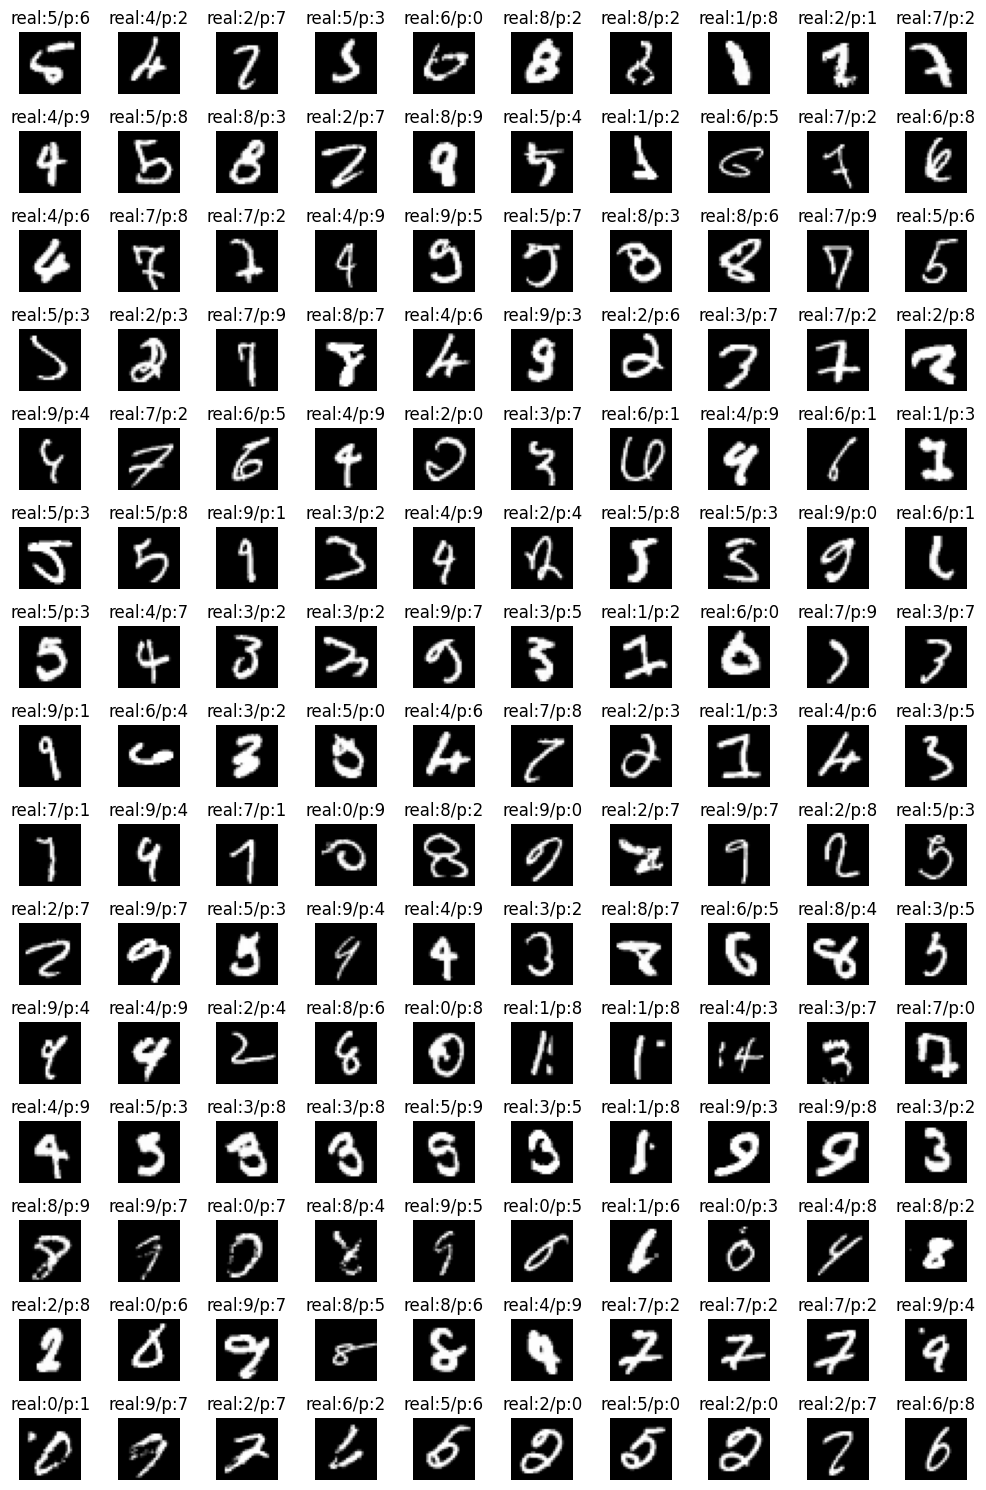

In [37]:
plt_row = 15
plt_col = 10
plt.rcParams['figure.figsize']=(plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
i = 0
cnt = 0 
while cnt<plt_row*plt_col and i<len(y_test):
    if (real[i]==pred[i]):
        i += 1
        continue
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'real:{real[i]}/p:{pred[i]}')
    i += 1
    cnt += 1
plt.tight_layout()
plt.show()

# 2. CNN
- convolutional layer -> pooling -> convolutional layer -> pooling -> Flatten(1차원으로 바꾸는작업) -> DNN

In [51]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
#CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
width=28
height=28
model = Sequential([
    Conv2D(filters=32, # 필터수
           kernel_size=3, #필터 사이즈 3x3
           padding='same', # zero-padding / padding='valid' 기본값
           input_shape=(width, height, 1),
           activation='relu'), # 28*28 1채널 이미지를 32개 필터로 특성맵 추출 => 28*28*32 특성맵
    MaxPool2D(pool_size=(2,2)), # 가로2, 세로2, 전체 4배 줄어듬
    Dropout(0.1),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 6, 6, 64)         

In [55]:
%%time
# 1. 데이터 가져오기 및 전처리
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train 데이터 6만개 => Train(5만개) + Val(1만개) 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]


# X data 스케일조정
train_X = X_train.astype('float32')/255.0
val_X = X_val.astype('float32')/255.0
test_X = X_test.astype('float32')/255.0

# y data 원핫인코딩
train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

# 2. 모델생성
width=28
height=28
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(width, height, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=10, activation='softmax'))

# 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# 학습하기
early_stopping = EarlyStopping(patience=10)
import os
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.makedirs(model_save_folder)
file = model_save_folder+'mnist-{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
hist = model.fit(train_X, train_Y,
                epochs=50, batch_size=32,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[early_stopping, checkpoint])

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9298
Epoch 1: val_accuracy improved from -inf to 0.98360, saving model to ./model\mnist-01-loss0.0553-val0.9836.h5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2276 - accuracy: 0.9299 - val_loss: 0.0553 - val_accuracy: 0.9836
Epoch 2/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9740
Epoch 2: val_accuracy improved from 0.98360 to 0.98460, saving model to ./model\mnist-02-loss0.0526-val0.9846.h5
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0862 - accuracy: 0.9740 - val_loss: 0.0526 - val_accuracy: 0.9846
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9799
Epoch 3: val_accuracy improved from 0.98460 to 0.98970, saving model to ./model\mnist-03-loss0.0350-val0.9897.h5
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0661 - accuracy: 0.9799 - val_l

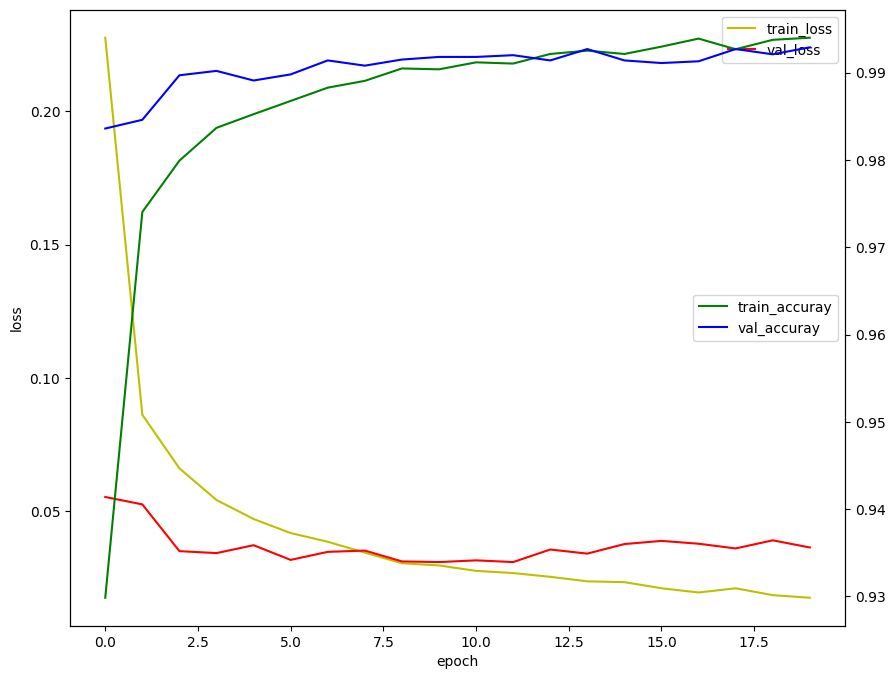

In [56]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuray')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [58]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y)
print('최종모델 :', acc, loss)

313/313 [==============================] - 2s 5ms/step - loss: 0.0272 - accuracy: 0.9934
최종모델 : 0.993399977684021 0.027175841853022575


In [64]:
model1 = load_model('./model/mnist-12-loss0.0309-val0.9920.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y)
print('model1 :', acc1, loss1)

313/313 [==============================] - 2s 5ms/step - loss: 0.0257 - accuracy: 0.9927
model1 : 0.9926999807357788 0.02566537819802761


In [67]:
#가장 좋은 모델 저장
save_model(model, filepath='./model/mnist.h5')

In [71]:
# 평가하기
y_hat = model.predict(test_X).argmax(axis=1)
y_hat

313/313 [==============================] - 2s 5ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [73]:
# 성능평가 (성능평가지표=교차표, 혼동행렬, acc, recall, precision, f1)를 위해 실제값, 예측값
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1,2,3,4,5,6,7,8,9
실제값,,,,,,,,,,
0,978,0,0,1,0,0,0,0,1,0
1,0,1132,0,1,0,2,0,0,0,0
2,1,0,1028,1,0,0,0,2,0,0
3,0,0,0,1006,0,2,0,0,2,0
4,0,0,0,0,978,0,2,0,0,2
5,1,0,0,4,0,885,1,0,1,0
6,4,2,0,0,1,2,949,0,0,0
7,0,2,5,0,0,0,0,1020,1,0
8,2,0,1,1,1,1,0,0,967,1


In [82]:
print('accuracy :', accuracy_score(y_test, y_hat))
# 다중분류의 타겟변수의 균형이 비슷하면 'macro', 균형이 안 잡힌 데이터면 'weighted'
print('recall :', recall_score(y_test, y_hat, average='weighted'))
print('precision :', precision_score(y_test, y_hat, average='weighted'))
print('f1_score :', f1_score(y_test, y_hat, average='weighted'))


accuracy : 0.9934
recall : 0.9934
precision : 0.993414606084066
f1_score : 0.9933972094790794


In [84]:
len(y_test) - len(y_test)*acc

66.00022315979004

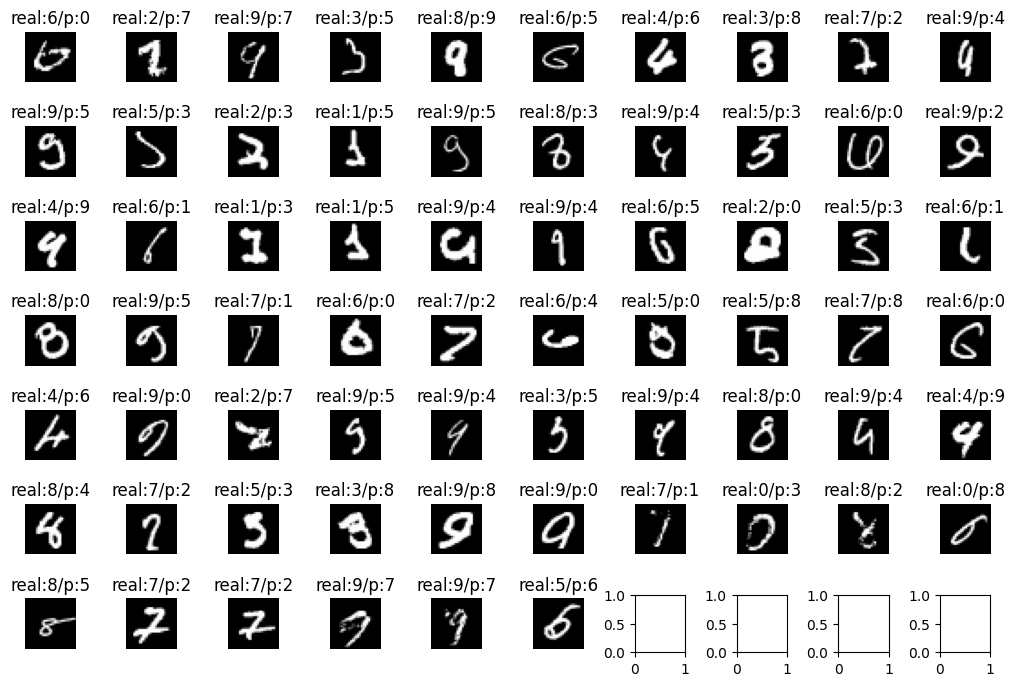

In [86]:
plt_row = 7
plt_col = 10
plt.rcParams['figure.figsize']=(plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
i = 0
cnt = 0 
while cnt<plt_row*plt_col and i<len(y_test):
    if (y_test[i]==y_hat[i]):
        i += 1
        continue
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'real:{y_test[i]}/p:{y_hat[i]}')
    i += 1
    cnt += 1
plt.tight_layout()
plt.show()